<a href="https://colab.research.google.com/github/MinaGong/customer_segmentation/blob/main/customer_segmentation_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Customer Segmentation for E-commerce: Clustering and Analysis

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd /content/drive/MyDrive/DataScience/ColabNotebooks/Projects/Portfolios/CustomerSegmentation

/content/drive/MyDrive/DataScience/ColabNotebooks/Projects/Portfolios/CustomerSegmentation


# 0. Project Objective
This notebook is the second part of the customer segmentation project. Building upon the exploratory data analysis (EDA) and feature engineering completed in the first notebook, our goal here is to apply and evaluate unsupervised clustering models to identify distinct customer groups.

We will leverage the processed and scaled dataset to perform the following steps:

1. **K-Means Clustering**:

* Determine the optimal number of clusters (k) using the Elbow Method.
* Train the K-Means model and assign customers to clusters.
* Analyze the characteristics of each cluster to understand their purchasing behavior.

2. **Model Evaluation and Visualization**:

* Use multiple clustering scores to quantitatively measure the quality and density of the clusters for the model.
* Employ Principal Component Analysis (PCA) to reduce the data's dimensionality and visualize the clusters in a 3D space.

4. **K-Means Cluster Analysis**:  
* Analyze the characteristics of each of the clusters by examining the mean values of the key features.
* Create cluster profiles and derive actionable insights about the different customer segments, which can inform future business strategies.

In [3]:
# Importing necessary Libraries
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import plotly.graph_objects as go
import seaborn as sns
import plotly.graph_objects as go


from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors

# 1. Data Loading
We will start by loading the preprocessed and scaled data files created in the previous feature engineering notebook.

In [4]:
# Load the scaled dataset
scaled_data = pd.read_pickle('X_scaled.pkl')
scaled_data.head()

,onehot__Cancel_status_Cancelled,onehot__Cancel_status_Completed,onehot__Gift_Seasonal_0,onehot__Gift_Seasonal_1,onehot__Bags_Accessories_0,onehot__Bags_Accessories_1,onehot__Kitchenware_0,onehot__Kitchenware_1,onehot__Home_Decor_0,onehot__Home_Decor_1,...,scaler__UnitPrice,scaler__Monthly_purchase,scaler__Monthly_spending,scaler__Weekday_purchase,scaler__Weekday_spending,scaler__Hour_purchase,scaler__Hour_spending,scaler__Recency,scaler__Frequency,scaler__Monetary
0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,-0.103914,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
1,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.205481,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
2,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,-0.030249,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
3,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.205481,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909
4,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.205481,0.90605,0.456247,0.472988,0.434293,-2.387699,-2.222019,1.96303,0.336539,-0.185909


# 2. K-Means Clustering
K-Means is a popular partitioning algorithm that groups data into a pre-defined number of clusters (k). It works by minimizing the variance within each cluster, creating groups where data points are close to their cluster's centroid.

## 2.1. Finding the Optimal Number of Clusters (k) with the Elbow Method
The Elbow Method helps us choose the optimal `k` by running K-Means for a range of `k` values and plotting the inertia (sum of squared distances of samples to their closest cluster center). The "elbow" of the curve—the point where the rate of decrease in inertia sharply slows—suggests a good value for `k`.

In [5]:
# Calculate inertia for a range of k values to find the optimal number of clusters
kmeans_inertia = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    kmeans_inertia.append(kmeans.inertia_)

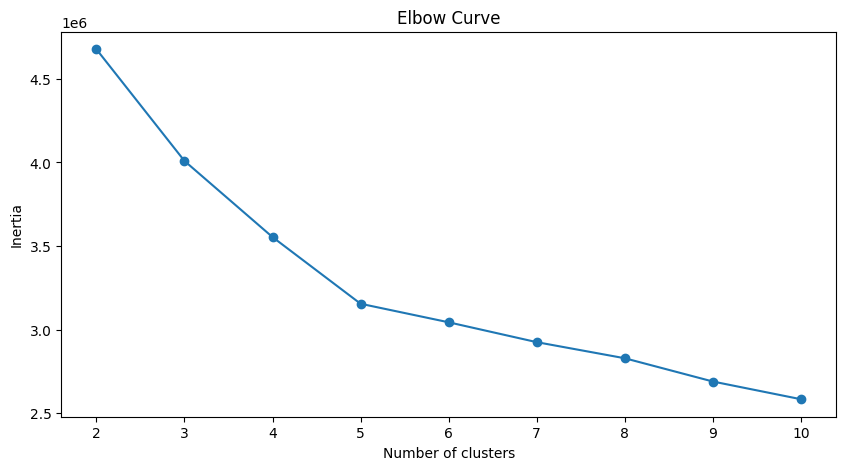

In [6]:
# Plot the elbow curve
plt.figure(figsize=(10, 5))
plt.plot(range(2, 11), kmeans_inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Curve')
plt.show()

The “elbow” is around k=5 because it’s the last point where adding another cluster gives a substantial benefit before the curve flattens. This gives a balance between compact, meaningful clusters and avoiding overfitting with too many small clusters.

## 2.2. Fitting the K-Means Model
Now we will fit the K-Means model with our chosen `k=5`.

In [7]:
# Keep the number of clusters as 5
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(scaled_data)

KMeans(n_clusters=5, random_state=42)

## 2.3. Dimension Reduction with PCA
Principal Component Analysis (PCA) is a dimensionality reduction technique used here to project our high-dimensional data onto a 3D space for visualization. This allows us to see the separation of the clusters.

In [8]:
# PCA with 3 components
pca = PCA(n_components=3)
pca_data = pca.fit_transform(scaled_data)
pca_data = pd.DataFrame(pca_data, columns=['PC1', 'PC2', 'PC3'])
pca_data['KMeans_cluster'] = kmeans.labels_

# 4. Model Evaluation

## 4.1 Cluster Visualization

In [ ]:
# Visualize the clusters in 3D scatter plot by plotly
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=pca_data['PC1'],
    y=pca_data['PC2'],
    z=pca_data['PC3'],
    mode='markers',
    marker=dict(color=pca_data['KMeans_cluster'], colorscale='Viridis', size=5, opacity=0.4)
))

fig.update_layout(
    title='3D PCA of K-Means Clusters',
    scene=dict(
        xaxis_title='PC1',
        yaxis_title='PC2',
        zaxis_title='PC3',
        aspectmode='cube'
    ),
    width=900,
    height=600,
)
fig.show()

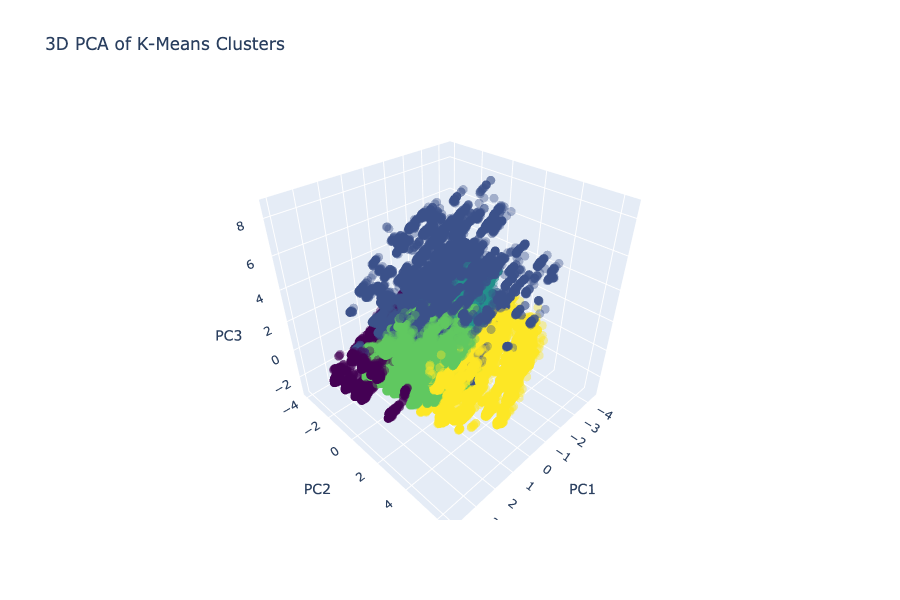

In [21]:
from IPython.display import Image, display

image_path = "/content/drive/MyDrive/DataScience/ColabNotebooks/Projects/Portfolios/CustomerSegmentation/cluster_plot.png"


display(Image(filename=image_path))

* **Note on Plotly Visualization:** While the code above generates an interactive 3D Plotly chart, GitHub's rendering of Jupyter Notebooks typically displays static outputs. To ensure the visualization is viewable when hosted on GitHub, a screenshot of the 3D plot has been included below. For the interactive experience, please run this notebook in a compatible environment like Google Colab.

The 3D PCA visualization of K-Means clustering shows that the customer dataset can be meaningfully segmented into five distinct groups, with clusters appearing relatively well-separated in the reduced feature space. While some overlap exists due to dimensionality compression, each cluster demonstrates different density and spread, indicating varying customer behaviors — for example, compact groups likely represent consistent purchasing patterns, while broader clusters suggest more diverse spending habits.

Overall, the plot validates that K-Means has identified meaningful customer segments that can be further profiled to reveal business personas such as loyal high-value customers, occasional buyers, and potential churn risks.

## 4.2 Cluster Scores
There are multiple evaluation metrics to quantify the quality of clustering.


### 4.2.1 Silhouette Score
The Silhouette Score measures how similar a data point is to its own cluster compared to other clusters. The score ranges from -1 to 1, where a high value indicates that the object is well-matched to its own cluster and poorly matched to neighboring clusters.

In [10]:
# Calculate Silhouette Score for K-Means
kmeans_silhouette = silhouette_score(scaled_data, kmeans.labels_)
print(f"Silhouette Score for K-Means: {kmeans_silhouette:.4f}")

Silhouette Score for K-Means: 0.1838


The Silhouette Score is modest, meaning that clusters are somewhat overlapping and not extremely well-separated.
This is common in customer data, where behaviors blend and boundaries are fuzzy.

### 4.2.2 Calinski Harabasz Score
The Calinski Harabasz Score (also known as the Variance Ratio Criterion) evaluates the quality of clusters by measuring the ratio of the sum of between-cluster dispersion to the sum of within-cluster dispersion for all clusters. A higher Calinski-Harabasz score indicates better-defined clusters that are dense and well-separated. It is generally a fast metric to compute.

In [11]:
# Calculate Calinski Harabasz Score for K-Means
kmeans_calinski_harabasz = calinski_harabasz_score(scaled_data, kmeans.labels_)
print(f"Calinski Harabasz Score for K-Means: {kmeans_calinski_harabasz:.4f}")

Calinski Harabasz Score for K-Means: 62268.0567


Calinski Harabasz score is very large, indicating that clusters are globally well-separated relative to their size.
This suggests that despite overlap, the clustering captures real structure in the data.

### 4.2.3 Davies Bouldin Score
The Calinski Harabasz Score measures the average similarity between each cluster and its most similar one, where similarity is a ratio of within-cluster distances to between-cluster distances. The score ranges from 0 upwards, with lower values indicating better clustering. A score of 0 represents the best possible clustering, where each cluster is maximally compact and far from all other clusters.

In [12]:
# Calculate Davies Bouldin Score for K-Means
kmeans_davies_bouldin = davies_bouldin_score(scaled_data, kmeans.labels_)
print(f"Davies Bouldin Score for K-Means: {kmeans_davies_bouldin:.4f}")

Davies Bouldin Score for K-Means: 1.5732


A value around 1.5 is reasonable (1–2: moderate/good separation), meaning clusters are distinct but still share similarities.

**Evaluation Results**:
The clustering evaluation metrics indicate that the K-Means segmentation is valid and meaningful. While the silhouette score (0.18) suggests some overlap between clusters, the very high Calinski–Harabasz score (62,268) confirms strong overall separation, and the Davies–Bouldin index (1.57) reflects reasonably distinct groupings. Taken together, the results support that the chosen clusters capture actionable customer segments, even if boundaries are not perfectly sharp.

## 4.3 Business Insight
Also, since I want 4–6 stable, interpretable segments with centroids I can profile (VIPs, one-timers, bargain hunters)m K-Means gives fixed segment count and stable centroids which is easy to turn into personas and target policies. Thus I will use K-Means (k≈5) for further creating customer profiles.

## 5. Cluster Profile
Based on clusters from KMeans (k=5) clustering, I will build cluster profiles to turn raw clusters into business personas.

In [13]:
# load the feature engineered data
data = pd.read_pickle('X_processed.pkl')
data['Cluster'] = kmeans.labels_
data.head()

,Quantity,UnitPrice,Cancel_status,Gift_Seasonal,Bags_Accessories,Kitchenware,Home_Decor,Household,UK_transaction,TotalPrice_range,...,Weekday_spending,Hour_purchase,Hour_spending,Holiday_season,Is_Weekday,Is_Daytime,Recency,Frequency,Monetary,Cluster
0,6,2.55,Completed,1,0,0,1,0,UK,Low,...,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19,4
1,6,3.39,Completed,0,0,0,0,1,UK,Low,...,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19,4
2,8,2.75,Completed,1,0,1,0,0,UK,Low,...,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19,4
3,6,3.39,Completed,0,0,0,0,1,UK,Low,...,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19,4
4,6,3.39,Completed,1,0,0,0,0,UK,Low,...,1201334.52,559,210698.12,Christmas,Weekday,Nighttime,373,35,4767.19,4


In [14]:
# Numeric features and categorical features
numeric_features = ['Quantity', 'UnitPrice', 'Monthly_purchase', 'Monthly_spending',
                    'Weekday_purchase', 'Weekday_spending', 'Hour_purchase', 'Hour_spending',
                    'Recency', 'Frequency', 'Monetary']

categorical_features = ['Cancel_status', 'Gift_Seasonal', 'Bags_Accessories', 'Kitchenware',
                        'Home_Decor', 'Household', 'UK_transaction', 'TotalPrice_range',
                        'Holiday_season', 'Is_Weekday', 'Is_Daytime']

In [15]:
#  Numeric features summary (mean + median per cluster)
numeric_summary = data.groupby("Cluster")[numeric_features].agg(["mean", "median"]).round(2)
pd.DataFrame(numeric_summary)

Quantity        UnitPrice        Monthly_purchase          \
            mean median      mean median             mean  median   
Cluster                                                             
0           6.35    3.0      2.73   1.95          1868.88  1866.0   
1           9.75    3.0      2.75   1.65          1874.86  1866.0   
2           9.83    6.0      2.92   1.95          1454.36  1409.0   
3           9.20    6.0      2.73   1.95          2296.20  2005.0   
4           9.76    6.0      2.94   1.95          1817.98  1650.0   

        Monthly_spending            Weekday_purchase          ...  \
                    mean     median             mean  median  ...   
Cluster                                                       ...   
0              628840.65  701857.82          2249.00  2249.0  ...   
1              628707.46  701857.82          3346.42  3405.0  ...   
2              458081.51  446838.48          3519.70  3405.0  ...   
3              809887.33  753854.90          3510.35  3405.0  ...   
4              607159.24  517317.91          3671.52  3656.0  ...   

        Hour_purchase         Hour_spending            Recency         \
                 mean  median          mean     median    mean median   
Cluster                                                                 
0             2537.80  2427.0     839849.74  811448.61  146.19  117.0   
1             2390.55  2384.0     798661.67  811448.61  139.19  116.0   
2             2572.08  2427.0     864799.14  844089.64  236.06  238.0   
3             2595.07  2427.0     871461.17  844089.64   43.32   42.0   
4              958.03  1259.0     294224.48  330525.77  147.27  129.0   

        Frequency         Monetary            
             mean median      mean    median  
Cluster                                       
0            9.53    6.0   2959.77   1900.66  
1          171.88  165.0  64388.99  38304.91  
2           13.29    8.0   4857.40   2591.47  
3           10.57    6.0   5419.27   2150.65  
4           12.39    7.0   5900.93   2301.63  

[5 rows x 22 columns]

In [16]:
# Categorical features summary (proportion of each category per cluster)
categorical_summary = {}
for col in categorical_features:
    # Handle categorical columns by getting value counts percentage per cluster
    summary = data.groupby("Cluster")[col].value_counts(normalize=True).unstack().fillna(0).round(2)
    categorical_summary[col] = summary
categorical_summary = pd.concat(categorical_summary.values(), axis=1, keys=categorical_summary.keys())
categorical_summary

Cancel_status           Gift_Seasonal       Bags_Accessories        \
            Cancelled Completed             0     1                0     1   
Cluster                                                                      
0                0.00      1.00          0.74  0.26             0.90  0.10   
1                0.01      0.99          0.78  0.22             0.89  0.11   
2                0.01      0.99          0.78  0.22             0.88  0.12   
3                0.01      0.99          0.70  0.30             0.90  0.10   
4                0.01      0.99          0.75  0.25             0.90  0.10   

        Kitchenware       Home_Decor        ... TotalPrice_range               \
                  0     1          0     1  ...              Low Medium  High   
Cluster                                     ...                                 
0              0.81  0.19       0.77  0.23  ...             0.97   0.03  0.00   
1              0.81  0.19       0.77  0.23  ...             0.92   0.08  0.01   
2              0.79  0.21       0.77  0.23  ...             0.94   0.05  0.00   
3              0.81  0.19       0.78  0.22  ...             0.95   0.04  0.00   
4              0.80  0.20       0.78  0.22  ...             0.94   0.05  0.00   

                  Holiday_season               Is_Weekday         Is_Daytime  \
        Very High      Christmas Non-Christmas    Weekday Weekend    Daytime   
Cluster                                                                        
0             0.0           0.20          0.80       0.00    1.00       1.00   
1             0.0           0.18          0.82       0.89    0.11       0.95   
2             0.0           0.32          0.68       1.00    0.00       1.00   
3             0.0           0.10          0.90       1.00    0.00       1.00   
4             0.0           0.19          0.81       1.00    0.00       0.54   

                   
        Nighttime  
Cluster            
0            0.00  
1            0.05  
2            0.00  
3            0.00  
4            0.46  

[5 rows x 24 columns]

In [17]:
# Cluster size
cluster_size = data["Cluster"].value_counts(normalize=True).round(3) * 100
cluster_size = cluster_size.rename("% of Customers")
pd.DataFrame(cluster_size).sort_values(by='% of Customers', ascending=False)

,% of Customers
Cluster,
2,36.9
3,26.9
4,15.4
0,15.1
1,5.6


In [18]:
# Combine summaries
cluster_profile = pd.concat([numeric_summary, categorical_summary, cluster_size], axis=1)
cluster_profile


,"(Quantity, mean)","(Quantity, median)","(UnitPrice, mean)","(UnitPrice, median)","(Monthly_purchase, mean)","(Monthly_purchase, median)","(Monthly_spending, mean)","(Monthly_spending, median)","(Weekday_purchase, mean)","(Weekday_purchase, median)",...,"(TotalPrice_range, Medium)","(TotalPrice_range, High)","(TotalPrice_range, Very High)","(Holiday_season, Christmas)","(Holiday_season, Non-Christmas)","(Is_Weekday, Weekday)","(Is_Weekday, Weekend)","(Is_Daytime, Daytime)","(Is_Daytime, Nighttime)",% of Customers
Cluster,,,,,,,,,,,,,,,,,,,,,
0,6.35,3.0,2.73,1.95,1868.88,1866.0,628840.65,701857.82,2249.00,2249.0,...,0.03,0.00,0.0,0.20,0.80,0.00,1.00,1.00,0.00,15.1
1,9.75,3.0,2.75,1.65,1874.86,1866.0,628707.46,701857.82,3346.42,3405.0,...,0.08,0.01,0.0,0.18,0.82,0.89,0.11,0.95,0.05,5.6
2,9.83,6.0,2.92,1.95,1454.36,1409.0,458081.51,446838.48,3519.70,3405.0,...,0.05,0.00,0.0,0.32,0.68,1.00,0.00,1.00,0.00,36.9
3,9.20,6.0,2.73,1.95,2296.20,2005.0,809887.33,753854.90,3510.35,3405.0,...,0.04,0.00,0.0,0.10,0.90,1.00,0.00,1.00,0.00,26.9
4,9.76,6.0,2.94,1.95,1817.98,1650.0,607159.24,517317.91,3671.52,3656.0,...,0.05,0.00,0.0,0.19,0.81,1.00,0.00,0.54,0.46,15.4


In [19]:
cluster_profile.to_csv('cluster_profile.csv')

# 6. Conclustion
Based on the cluster profile, I draw 5 customer segmentations and each cluster's business persona.

### Cluster 0 (15.1% of customers)
* Moderate quantity (mean 6.3, median 3).
* Medium monthly purchases & spending (~1.8k orders, £629k avg monthly).
* Weekend shoppers (100% of transactions on weekends).
* Higher share of Christmas purchases (20%).

**Persona: 🎄 Seasonal weekend buyers**
They purchase mostly during weekends and around holidays, moderate spenders.

### Cluster 2 (36.9% of customers)
* Largest cluster (37%).
* Lower monthly purchases (1.4k) and spending (£458k).
* Strong Christmas focus (32%) — highest among all clusters.
* All transactions on weekdays (100%).

**Persona: 🎁 Christmas-focused weekday buyers**
It is a majority group, spend moderately, strongly seasonal around holidays.


### Cluster 3 (26.9% of customers)
* Highest spending cluster (~£810k monthly).
* Highest monthly purchases (~2.3k).
* Almost exclusively weekday, daytime buyers.
* Low holiday dependency (10%).
**Persona: 👑 VIP loyalists**
They are frequent, high-spending weekday shoppers, stable across the year, not holiday-driven.



### Cluster 4 (15.4% of customers)
* Balanced order size (Quantity ~9.7, median 6).
* Spending (~£607k monthly).
* Daytime vs nighttime mix → 54% day, 46% night (only cluster with substantial night activity).
* Moderate holiday purchases (19%).

**Persona: 🌙 Night-active steady buyers**
They  shop across times of day, balanced purchases, medium spenders.